# Install TensorFlow 2.0 Preview

* TensorFlow 2.0 preview is available to test
* Colab is the easiest way to try it
* We can install TensorFlow 2.0 Preview using the below code cell

* Upgrading to TF 2.0 will be a critical process if you already have projects/code in other TF versions
* tf_upgrade_v2 tool helps in converting existing TF code to TF 2.0
* This tool is automatically installed by pip install for TensorFlow 1.13 and later
* Below is an example of how to use this tool:

`tf_upgrade_v2 --infile script.py --outfile script-upgraded.py`

# Download and extract Food 101 Dataset

* Add all the imports

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [2]:
# Check TF version and whether GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.12.0
/device:GPU:0


In [3]:
# Clone tensorflow/examples repo which has images to evaluate trained model
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 23600, done.
remote: Counting objects: 100% (560/560), done.
remote: Compressing objects: 100% (336/336), done.
remote: Total 23600 (delta 164), reused 509 (delta 144), pack-reused 23040
Receiving objects: 100% (23600/23600), 44.09 MiB | 18.01 MiB/s, done.
Resolving deltas: 100% (12821/12821), done.


In [4]:
# Helper function to download data and extract

def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

* The Food-101 dataset is 5GB in size. This might take some time to finish..

In [ ]:
# Download data and extract it to folder
get_data_extract()

4996278331/4996278331 [==============================] - 294s 0us/step
Dataset downloaded and extracted!


# Understand dataset structure and files

* The dataset being used is [Food 101](https://www.vision.ee.ethz.ch/datasets_extra/food-101/)
* This dataset has 101000 images in total. It's a food dataset with 101 categories(multiclass)
* Each type of food has 750 training samples and 250 test samples
* Note found on the webpage of the dataset :  
* On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
* The entire dataset is 5GB in size

In [ ]:
# Check the extracted dataset folder
os.listdir('food-101/')

['license_agreement.txt', 'meta', 'images', 'README.txt']

**images** folder contains 101 folders with 1000 images  each  
Each folder contains images of a specific food class

In [ ]:
os.listdir('food-101/images')

['spaghetti_carbonara',
 'creme_brulee',
 'bibimbap',
 'ice_cream',
 'croque_madame',
 'mussels',
 'fried_calamari',
 'steak',
 'red_velvet_cake',
 'takoyaki',
 'nachos',
 'oysters',
 'omelette',
 'prime_rib',
 'sashimi',
 'gnocchi',
 'cup_cakes',
 'pulled_pork_sandwich',
 'edamame',
 'fried_rice',
 'falafel',
 'churros',
 'lobster_roll_sandwich',
 'tiramisu',
 'spring_rolls',
 'breakfast_burrito',
 'crab_cakes',
 'french_fries',
 'baby_back_ribs',
 'lasagna',
 'greek_salad',
 'ravioli',
 'miso_soup',
 'strawberry_shortcake',
 'french_toast',
 'gyoza',
 'french_onion_soup',
 'beef_tartare',
 'caesar_salad',
 'grilled_cheese_sandwich',
 'chicken_curry',
 'macaroni_and_cheese',
 'chocolate_cake',
 'lobster_bisque',
 'hot_and_sour_soup',
 'escargots',
 'shrimp_and_grits',
 'poutine',
 'chicken_quesadilla',
 'seaweed_salad',
 'fish_and_chips',
 'baklava',
 'tuna_tartare',
 'beef_carpaccio',
 'paella',
 'guacamole',
 'bread_pudding',
 'beet_salad',
 'hamburger',
 'hot_dog',
 'clam_chowder',

**meta** folder contains the text files - train.txt and test.txt  
**train.txt** contains the list of images that belong to training set  
**test.txt** contains the list of images that belong to test set  
**classes.txt** contains the list of all classes of food

In [ ]:
os.listdir('food-101/meta')

['train.json',
 'test.txt',
 'classes.txt',
 'train.txt',
 'test.json',
 'labels.txt']

# Visualize random image from each of the 101 classes

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id]
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)

plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


# Split the image data into train and test using train.txt and test.txt

In [ ]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [ ]:
# Check how many files are in the train folder

train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [ ]:
# Check how many files are in the test folder
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


# Create a subset of data with few classes (10)

* We now have train and test data ready  
* But to experiment and try different architectures, working on the whole data with 101 classes takes a lot of time and computation  
* To proceed with further experiments, I am creating train_min and test_mini, limiting the dataset to 3 classes  
* Since the original problem is multiclass classification which makes key aspects of architectural decisions different from that of binary classification, choosing 3 classes is a good start instead of 2

In [ ]:
# List of all 101 types of foods(sorted alphabetically)
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:
# picking 3 food items and generating separate data folders for the same
food_list = ['samosa','pizza','omelette','apple_pie','baby_back_ribs','baklava','waffles','tacos','strawberry_shortcake','seaweed_salad']
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into samosa
Copying images into pizza
Copying images into omelette
Copying images into apple_pie
Copying images into baby_back_ribs
Copying images into baklava
Copying images into waffles
Copying images into tacos
Copying images into strawberry_shortcake
Copying images into seaweed_salad


In [ ]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101/train_mini")])
print(train_files)

Total number of samples in train folder
7500


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into samosa
Copying images into pizza
Copying images into omelette
Copying images into apple_pie
Copying images into baby_back_ribs
Copying images into baklava
Copying images into waffles
Copying images into tacos
Copying images into strawberry_shortcake
Copying images into seaweed_salad


In [ ]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101/test_mini")])
print(test_files)

Total number of samples in test folder
2500


In [ ]:
# import os
# import shutil

# # Create the 'validation_mini' folder if it doesn't exist
# if not os.path.exists('food-101/validation_mini'):
#     os.makedirs('food-101/validation_mini')

# # Define the list of food items
# food_list = ['samosa','pizza','omelette','apple_pie','baby_back_ribs','baklava','waffles','tacos','strawberry_shortcake','seaweed_salad']

# # Path to the original 'train_mini' folder
# train_folder = 'food-101/train_mini'

# # Path to the new 'validation_mini' folder
# validation_folder = 'food-101/validation_mini'

# # Split ratio (0.2 for 20% validation)
# split_ratio = 0.2

# # Loop through each food item and create the 'validation_mini' folder
# for food in food_list:
#     # Create the folder for the current food item in 'validation_mini'
#     food_folder_val = os.path.join(validation_folder, food)
#     if not os.path.exists(food_folder_val):
#         os.makedirs(food_folder_val)

#     # List all image files for the current food item in 'train_mini'
#     food_folder_train = os.path.join(train_folder, food)
#     image_files = os.listdir(food_folder_train)

#     # Calculate the number of images to move to 'validation_mini'
#     num_images_val = int(len(image_files) * split_ratio)

#     # Move the images to 'validation_mini'
#     for i in range(num_images_val):
#         image_file = image_files[i]
#         src_path = os.path.join(food_folder_train, image_file)
#         dst_path = os.path.join(food_folder_val, image_file)
#         shutil.move(src_path, dst_path)


## Expeiment code

### Semisupervised

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Define the list of food items
food_list = ['samosa','pizza','omelette','apple_pie','baby_back_ribs','baklava','waffles','tacos','strawberry_shortcake','seaweed_salad']
n_classes = 10
# Data generators for labeled and test data
img_width, img_height = 180, 180
train_folder = "food-101/train_mini"
test_folder = "food-101/test_mini"

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Define the CNN model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(len(food_list), activation='softmax'))


##############################################################################################################
# inception = InceptionV3(weights='imagenet', include_top=False)
# x = inception.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(32,activation='relu')(x)
# x = Dropout(0.2)(x)

# predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

# model = Model(inputs=inception.input, outputs=predictions)

###########################################################################################################

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the labeled data
history = model.fit(train_generator, validation_data=validation_generator, epochs=5)

# Make predictions on the unlabeled data
# unlabeled_data = test_generator.next()[0]
# unlabeled_predictions = model.predict(test_generator)
# pseudo_labels = np.argmax(unlabeled_predictions, axis=1)



# Initialize empty arrays to store pseudo-labeled data and labels
pseudo_labeled_data = []
pseudo_labels = []

# Iterate through batches of unlabeled data and perform pseudo-labeling
for batch in test_generator:
    batch_data = batch[0]
    batch_predictions = model.predict(batch_data)
    batch_pseudo_labels = np.argmax(batch_predictions, axis=1)

    pseudo_labeled_data.append(batch_data)
    pseudo_labels.append(batch_pseudo_labels)

    if len(pseudo_labeled_data) * test_generator.batch_size >= len(test_generator.filenames):
        break

# Combine pseudo-labeled data and labels
pseudo_labeled_data = np.concatenate(pseudo_labeled_data, axis=0)
pseudo_labels = np.concatenate(pseudo_labels, axis=0)

# Combine the labeled and pseudo-labeled data
combined_data = np.concatenate((train_generator[0][0], pseudo_labeled_data), axis=0)
combined_labels = np.concatenate((train_generator[0][1], pseudo_labels), axis=0)

# Shuffle the combined data
combined_data, combined_labels = shuffle(combined_data, combined_labels, random_state=0)

# Retrain the model on the combined data
history1_ = model.fit(combined_data, combined_labels, epochs=5)

# Evaluate the model on the test data
accuracy = model.evaluate(test_generator)[1]
print(f"Accuracy: {accuracy}")


Found 6000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/5
188/188 [==============================] - 86s 398ms/step - loss: 2.1992 - accuracy: 0.1782 - val_loss: 2.1509 - val_accuracy: 0.1873
Epoch 2/5
188/188 [==============================] - 68s 360ms/step - loss: 2.0927 - accuracy: 0.2427 - val_loss: 2.0966 - val_accuracy: 0.2400
Epoch 3/5
188/188 [==============================] - 75s 402ms/step - loss: 2.0373 - accuracy: 0.2642 - val_loss: 2.0031 - val_accuracy: 0.2740
Epoch 4/5
188/188 [==============================] - 68s 363ms/step - loss: 1.9876 - accuracy: 0.2748 - val_loss: 1.9850 - val_accuracy: 0.2693
Epoch 5/5
1/1 [==============================] - 0s 145ms/step
Epoch 1/5
80/80 [==============================] - 1s 18ms/step - loss: 0.9833 - accuracy: 0.7054
Epoch 2/5
80/80 [==============================] - 1s 16ms/step - loss: 0.7966 - accuracy: 0.7496
Epoch 3/5
80/80 [===================

In [ ]:

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

# Function to calculate top-k accuracy
def top_k_accuracy(y_true, y_pred, k):
    top_indices = np.argsort(y_pred)[:, -k:]
    correct_indices = np.argmax(y_true, axis=1)
    hits = np.any(top_indices == correct_indices.reshape((-1, 1)), axis=1)
    return np.mean(hits)

# Get one-hot encoded test labels
test_labels_one_hot = np.eye(len(food_list))[test_generator.labels]

# Get the test predictions
test_predictions = model.predict(test_generator)

# Calculate top-1, top-5, and top-10 accuracies
top1_acc_scr = top_k_accuracy(test_labels_one_hot, test_predictions, k=1)
top5_acc_scr = top_k_accuracy(test_labels_one_hot, test_predictions, k=5)
top10_acc_scr = top_k_accuracy(test_labels_one_hot, test_predictions, k=10)

print(f"Top-1 Accuracy: {top1_acc_scr}")
print(f"Top-5 Accuracy: {top5_acc_scr}")
print(f"Top-10 Accuracy: {top10_acc_scr}")




79/79 [==============================] - 6s 72ms/step - loss: 5.6734 - accuracy: 0.2840
Test Accuracy: 0.2840000092983246
79/79 [==============================] - 6s 73ms/step
Top-1 Accuracy: 0.284
Top-5 Accuracy: 0.7124
Top-10 Accuracy: 1.0


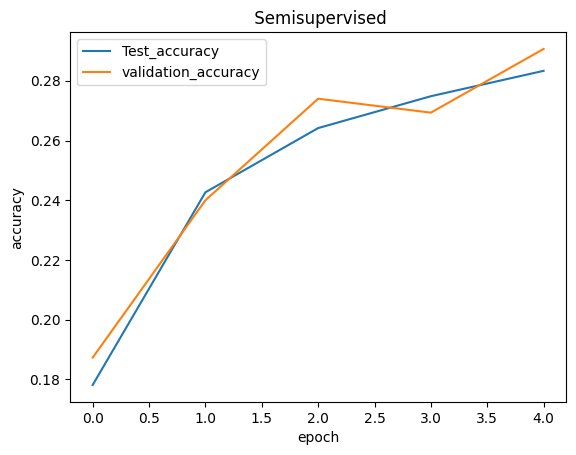

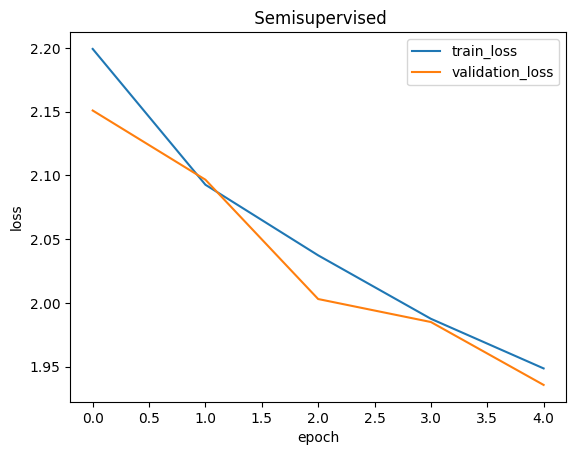

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Test_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,' Semisupervised')
plot_loss(history,' Semisupervised')

### Model-2

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

# Define the list of food items
food_list = ['samosa', 'pizza', 'omelette', 'apple_pie', 'baby_back_ribs', 'baklava', 'waffles', 'tacos', 'strawberry_shortcake', 'seaweed_salad']

# Data generators for labeled and test data
img_width, img_height = 180, 180
train_folder = "food-101/train_mini"
test_folder = "food-101/test_mini"

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

#####################################################################################################################################
# Load the pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add a global average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(food_list), activation='softmax')(x)

# Create the model with InceptionV3 base and custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained InceptionV3 base
for layer in base_model.layers:
    layer.trainable = False
#############################################################################################################
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the labeled data
history = model.fit(train_generator, validation_data=validation_generator, epochs=8)

# Initialize empty arrays to store pseudo-labeled data and labels
pseudo_labeled_data = []
pseudo_labels = []

# Iterate through batches of unlabeled data and perform pseudo-labeling
for batch in test_generator:
    batch_data = batch[0]
    batch_predictions = model.predict(batch_data)
    batch_pseudo_labels = np.argmax(batch_predictions, axis=1)

    pseudo_labeled_data.append(batch_data)
    pseudo_labels.append(batch_pseudo_labels)

    if len(pseudo_labeled_data) * test_generator.batch_size >= len(test_generator.filenames):
        break

# Combine pseudo-labeled data and labels
pseudo_labeled_data = np.concatenate(pseudo_labeled_data, axis=0)
pseudo_labels = np.concatenate(pseudo_labels, axis=0)

# Combine the labeled and pseudo-labeled data
combined_data = np.concatenate((train_generator[0][0], pseudo_labeled_data), axis=0)
combined_labels = np.concatenate((train_generator[0][1], pseudo_labels), axis=0)


# Shuffle the combined data
combined_data, combined_labels = shuffle(combined_data, combined_labels, random_state=0)

# Retrain the model on the combined data and fine-tune the InceptionV3 base layers
# for layer in base_model.layers[-50:]:
#     layer.trainable = True

# Compile the model again after unfreezing the layers
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the combined data with fine-tuned InceptionV3 layers
history1_ = model.fit(combined_data, combined_labels, epochs=10)

# Evaluate the model on the test data
accuracy = model.evaluate(test_generator)[1]
print(f"Accuracy: {accuracy}")


Found 6000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/8
188/188 [==============================] - 84s 418ms/step - loss: 1.7415 - accuracy: 0.4033 - val_loss: 1.2290 - val_accuracy: 0.5947
Epoch 2/8
188/188 [==============================] - 73s 387ms/step - loss: 1.3611 - accuracy: 0.5323 - val_loss: 1.1076 - val_accuracy: 0.6180
Epoch 3/8
188/188 [==============================] - 73s 391ms/step - loss: 1.2756 - accuracy: 0.5563 - val_loss: 1.0055 - val_accuracy: 0.6747
Epoch 4/8
188/188 [==============================] - 74s 392ms/step - loss: 1.2400 - accuracy: 0.5727 - val_loss: 1.0222 - val_accuracy: 0.6620
Epoch 5/8
188/188 [==============================] - 79s 423ms/step - loss: 1.1980 - accuracy: 0.5897 - val_loss: 0.9463 - val_accuracy: 0.6893
Epoch 6/8
188/188 [==============================] - 74s 394ms/step - loss: 1.1242 - a

In [ ]:

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

# Function to calculate top-k accuracy
def top_k_accuracy(y_true, y_pred, k):
    top_indices = np.argsort(y_pred)[:, -k:]
    correct_indices = np.argmax(y_true, axis=1)
    hits = np.any(top_indices == correct_indices.reshape((-1, 1)), axis=1)
    return np.mean(hits)

# Get one-hot encoded test labels
test_labels_one_hot = np.eye(len(food_list))[test_generator.labels]

# Get the test predictions
test_predictions = model.predict(test_generator)

# Calculate top-1, top-5, and top-10 accuracies
top1_acc_inc = top_k_accuracy(test_labels_one_hot, test_predictions, k=1)
top5_acc_inc = top_k_accuracy(test_labels_one_hot, test_predictions, k=5)
top10_acc_inc = top_k_accuracy(test_labels_one_hot, test_predictions, k=10)

print(f"Top-1 Accuracy: {top1_acc_inc}")
print(f"Top-5 Accuracy: {top5_acc_inc}")
print(f"Top-10 Accuracy: {top10_acc_inc}")




79/79 [==============================] - 7s 87ms/step - loss: 1.1293 - accuracy: 0.7324
Test Accuracy: 0.7324000000953674
79/79 [==============================] - 8s 84ms/step
Top-1 Accuracy: 0.7324
Top-5 Accuracy: 0.9652
Top-10 Accuracy: 1.0


In [ ]:

# # Plot accuracy and loss curves
# def plot_accuracy(history, title):
#     plt.title(title)
#     plt.plot(history.history['accuracy'])
#     plt.plot(history.history['val_accuracy'])
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')
#     plt.show()

# def plot_loss(history, title):
#     plt.title(title)
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['Training loss', 'Validation loss'], loc='best')
#     plt.show()

# plot_accuracy(history, 'Training and Validation Accuracy (Before Fine-Tuning)')
# plot_loss(history, 'Training and Validation Loss (Before Fine-Tuning)')

# plot_accuracy(history1_, 'Training and Validation Accuracy (After Fine-Tuning)')
# plot_loss(history1_, 'Training and Validation Loss (After Fine-Tuning)')


In [ ]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

# Define the list of food items
food_list = ['samosa', 'pizza', 'omelette', 'apple_pie', 'baby_back_ribs', 'baklava', 'waffles', 'tacos', 'strawberry_shortcake', 'seaweed_salad']

# Data generators for labeled and test data
img_width, img_height = 180, 180
train_folder = "food-101/train_mini"
test_folder = "food-101/test_mini"

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


###################################################################################################################
# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add a global average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(food_list), activation='softmax')(x)

# Create the model with EfficientNetB0 base and custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained EfficientNetB0 base
for layer in base_model.layers:
    layer.trainable = False
#####################################################################################################
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the labeled data
history = model.fit(train_generator, validation_data=validation_generator, epochs=10)

# Initialize empty arrays to store pseudo-labeled data and labels
pseudo_labeled_data = []
pseudo_labels = []

# Iterate through batches of unlabeled data and perform pseudo-labeling
for batch in test_generator:
    batch_data = batch[0]
    batch_predictions = model.predict(batch_data)
    batch_pseudo_labels = np.argmax(batch_predictions, axis=1)

    pseudo_labeled_data.append(batch_data)
    pseudo_labels.append(batch_pseudo_labels)

    if len(pseudo_labeled_data) * test_generator.batch_size >= len(test_generator.filenames):
        break

# Combine pseudo-labeled data and labels
pseudo_labeled_data = np.concatenate(pseudo_labeled_data, axis=0)
pseudo_labels = np.concatenate(pseudo_labels, axis=0)

# Combine the labeled and pseudo-labeled data
combined_data = np.concatenate((train_generator[0][0], pseudo_labeled_data), axis=0)
combined_labels = np.concatenate((train_generator[0][1], pseudo_labels), axis=0)

# Shuffle the combined data
combined_data, combined_labels = shuffle(combined_data, combined_labels, random_state=0)

# # Retrain the model on the combined data and fine-tune the EfficientNetB0 base layers
# for layer in base_model.layers:
#     layer.trainable = True

# Compile the model again after unfreezing the layers
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the combined data with fine-tuned EfficientNetB0 layers
history1_ = model.fit(combined_data, combined_labels, validation_split=0.1, epochs=5)

# Evaluate the model on the test data
accuracy = model.evaluate(test_generator)[1]
print(f"Accuracy: {accuracy}")


Found 6000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
16804768/16804768 [==============================] - 2s 0us/step
Epoch 1/10
188/188 [==============================] - 86s 420ms/step - loss: 1.5011 - accuracy: 0.4972 - val_loss: 0.9326 - val_accuracy: 0.7060
Epoch 2/10
188/188 [==============================] - 72s 384ms/step - loss: 1.0447 - accuracy: 0.6557 - val_loss: 0.8312 - val_accuracy: 0.7380
Epoch 3/10
188/188 [==============================] - 71s 377ms/step - loss: 0.9467 - accuracy: 0.6792 - val_loss: 0.7842 - val_accuracy: 0.7440
Epoch 4/10
188/188 [==============================] - 72s 383ms/step - loss: 0.8773 - accuracy: 0.7103 - val_loss: 0.7519 - val_accuracy: 0.7527
Epoch 5/10
188/188 [==============================] - 78s 415ms/step - loss: 0.8364 - accuracy: 0.7225 - val_loss: 0.7709 - val_accuracy: 0.7447
Epoch 6/10
188/188 [==============================] - 72s 384ms/step - loss: 0.80

In [ ]:

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

# Function to calculate top-k accuracy
def top_k_accuracy(y_true, y_pred, k):
    top_indices = np.argsort(y_pred)[:, -k:]
    correct_indices = np.argmax(y_true, axis=1)
    hits = np.any(top_indices == correct_indices.reshape((-1, 1)), axis=1)
    return np.mean(hits)

# Get one-hot encoded test labels
test_labels_one_hot = np.eye(len(food_list))[test_generator.labels]

# Get the test predictions
test_predictions = model.predict(test_generator)

# Calculate top-1, top-5, and top-10 accuracies
top1_acc_eff = top_k_accuracy(test_labels_one_hot, test_predictions, k=1)
top5_acc_eff = top_k_accuracy(test_labels_one_hot, test_predictions, k=5)
top10_acc_eff = top_k_accuracy(test_labels_one_hot, test_predictions, k=10)

print(f"Top-1 Accuracy: {top1_acc_eff}")
print(f"Top-5 Accuracy: {top5_acc_eff}")
print(f"Top-10 Accuracy: {top10_acc_eff}")




79/79 [==============================] - 7s 87ms/step - loss: 0.6447 - accuracy: 0.8228
Test Accuracy: 0.8227999806404114
79/79 [==============================] - 8s 82ms/step
Top-1 Accuracy: 0.8228
Top-5 Accuracy: 0.9848
Top-10 Accuracy: 1.0


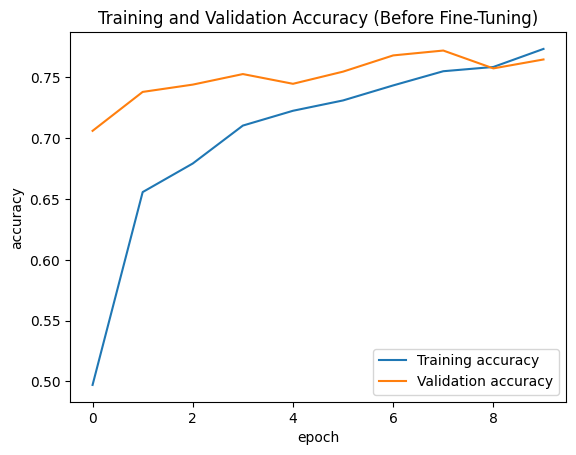

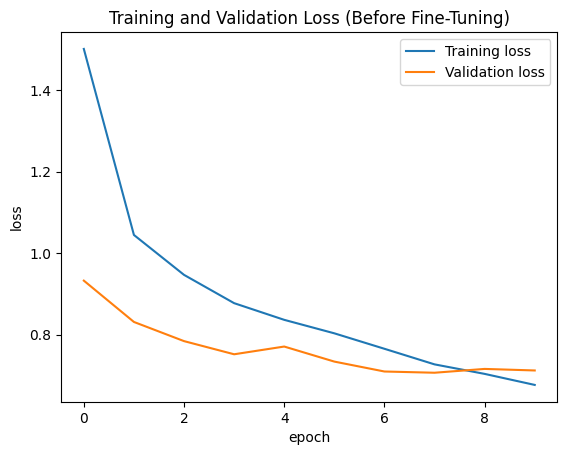

In [ ]:

# Plot accuracy and loss curves
def plot_accuracy(history, title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')
    plt.show()

def plot_loss(history, title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training loss', 'Validation loss'], loc='best')
    plt.show()

plot_accuracy(history, 'Training and Validation Accuracy (Before Fine-Tuning)')
plot_loss(history, 'Training and Validation Loss (Before Fine-Tuning)')

# plot_accuracy(history1_, 'Training and Validation Accuracy (After Fine-Tuning)')
# plot_loss(history1_, 'Training and Validation Loss (After Fine-Tuning)')


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

# Define the list of food items
food_list = ['samosa', 'pizza', 'omelette', 'apple_pie', 'baby_back_ribs', 'baklava', 'waffles', 'tacos', 'strawberry_shortcake', 'seaweed_salad']

# Data generators for labeled and test data
img_width, img_height = 180, 180
train_folder = "food-101/train_mini"
test_folder = "food-101/test_mini"

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Load the pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add a global average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(food_list), activation='softmax')(x)

# Create the model with DenseNet121 base and custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained DenseNet121 base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the labeled data
history = model.fit(train_generator, validation_data=validation_generator, epochs=5)

# Initialize empty arrays to store pseudo-labeled data and labels
pseudo_labeled_data = []
pseudo_labels = []

# Iterate through batches of unlabeled data and perform pseudo-labeling
for batch in test_generator:
    batch_data = batch[0]
    batch_predictions = model.predict(batch_data)
    batch_pseudo_labels = np.argmax(batch_predictions, axis=1)

    pseudo_labeled_data.append(batch_data)
    pseudo_labels.append(batch_pseudo_labels)

    if len(pseudo_labeled_data) * test_generator.batch_size >= len(test_generator.filenames):
        break

# Combine pseudo-labeled data and labels
pseudo_labeled_data = np.concatenate(pseudo_labeled_data, axis=0)
pseudo_labels = np.concatenate(pseudo_labels, axis=0)

# Combine the labeled and pseudo-labeled data
combined_data = np.concatenate((train_generator[0][0], pseudo_labeled_data), axis=0)
combined_labels = np.concatenate((train_generator[0][1], pseudo_labels), axis=0)


# Shuffle the combined data
combined_data, combined_labels = shuffle(combined_data, combined_labels, random_state=0)

# Retrain the model on the combined data and fine-tune the DenseNet121 base layers
for layer in base_model.layers:
    layer.trainable = True

# Compile the model again after unfreezing the layers
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the combined data with fine-tuned DenseNet121 layers
history1_ = model.fit(combined_data, combined_labels, validation_data=validation_generator, epochs=5)

# Evaluate the model on the test data
accuracy = model.evaluate(test_generator)[1]
print(f"Accuracy: {accuracy}")



Found 6000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
29084464/29084464 [==============================] - 3s 0us/step
Epoch 1/5
188/188 [==============================] - 88s 425ms/step - loss: 1.5991 - accuracy: 0.4685 - val_loss: 0.9962 - val_accuracy: 0.6860
Epoch 2/5
188/188 [==============================] - 74s 394ms/step - loss: 1.0930 - accuracy: 0.6330 - val_loss: 0.7939 - val_accuracy: 0.7467
Epoch 3/5
188/188 [==============================] - 74s 392ms/step - loss: 0.9480 - accuracy: 0.6863 - val_loss: 0.8252 - val_accuracy: 0.7213
Epoch 4/5
188/188 [==============================] - 79s 421ms/step - loss: 0.8721 - accuracy: 0.7073 - val_loss: 0.7799 - val_accuracy: 0.7493
Epoch 5/5
1/1 [==============================] - 4s 4s/step
Epoch 1/5
80/80 [==============================] - 110s 471ms/step - loss: 1.4936 - accuracy: 0.5312 - val_loss: 7.5535 - val_accuracy: 0.1940
Epoch 2/5
80/80 [==========

In [ ]:

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

# Function to calculate top-k accuracy
def top_k_accuracy(y_true, y_pred, k):
    top_indices = np.argsort(y_pred)[:, -k:]
    correct_indices = np.argmax(y_true, axis=1)
    hits = np.any(top_indices == correct_indices.reshape((-1, 1)), axis=1)
    return np.mean(hits)

# Get one-hot encoded test labels
test_labels_one_hot = np.eye(len(food_list))[test_generator.labels]

# Get the test predictions
test_predictions = model.predict(test_generator)

# Calculate top-1, top-5, and top-10 accuracies
top1_acc_dense121s = top_k_accuracy(test_labels_one_hot, test_predictions, k=1)
top5_acc_dense121s = top_k_accuracy(test_labels_one_hot, test_predictions, k=5)
top10_acc_dense121s = top_k_accuracy(test_labels_one_hot, test_predictions, k=10)

print(f"Top-1 Accuracy: {top1_acc_dense121s}")
print(f"Top-5 Accuracy: {top5_acc_dense121s}")
print(f"Top-10 Accuracy: {top10_acc_dense121s}")




79/79 [==============================] - 8s 98ms/step - loss: 2.6677 - accuracy: 0.4004
Test Accuracy: 0.4004000127315521
79/79 [==============================] - 10s 102ms/step
Top-1 Accuracy: 0.4004
Top-5 Accuracy: 0.834
Top-10 Accuracy: 1.0


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the list of food items
food_list = ['samosa', 'pizza', 'omelette', 'apple_pie', 'baby_back_ribs', 'baklava', 'waffles', 'tacos', 'strawberry_shortcake', 'seaweed_salad']

# Data generators for labeled and test data
img_width, img_height = 180, 180
train_folder = "food-101/train_mini"
test_folder = "food-101/test_mini"

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,         # New: Random rotation up to 20 degrees
    width_shift_range=0.1,     # New: Horizontal shift up to 10% of the image width
    height_shift_range=0.1,    # New: Vertical shift up to 10% of the image height
    brightness_range=(0.8, 1.2) # New: Random brightness adjustment
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Load the pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add a global average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(food_list), activation='softmax')(x)

# Create the model with DenseNet121 base and custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained DenseNet121 base
for layer in base_model.layers:
    layer.trainable = False

# Define a learning rate schedule for optimization
def lr_schedule(epoch):
    if epoch < 5:
        return 0.001
    elif epoch < 10:
        return 0.0005
    else:
        return 0.0001

# Compile the model with Adam optimizer and learning rate schedule
model.compile(optimizer=Adam(learning_rate=lr_schedule(0)), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the labeled data for a few epochs
history = model.fit(train_generator, validation_data=validation_generator, epochs=15)

# Initialize empty arrays to store pseudo-labeled data and labels
pseudo_labeled_data = []
pseudo_labels = []

# Iterate through batches of unlabeled data and perform pseudo-labeling
for batch in test_generator:
    batch_data = batch[0]
    batch_predictions = model.predict(batch_data)
    batch_pseudo_labels = np.argmax(batch_predictions, axis=1)

    pseudo_labeled_data.append(batch_data)
    pseudo_labels.append(batch_pseudo_labels)

    if len(pseudo_labeled_data) * test_generator.batch_size >= len(test_generator.filenames):
        break

# Combine pseudo-labeled data and labels
pseudo_labeled_data = np.concatenate(pseudo_labeled_data, axis=0)
pseudo_labels = np.concatenate(pseudo_labels, axis=0)

# Combine the labeled and pseudo-labeled data
combined_data = np.concatenate((train_generator[0][0], pseudo_labeled_data), axis=0)
combined_labels = np.concatenate((train_generator[0][1], pseudo_labels), axis=0)


# Shuffle the combined data
combined_data, combined_labels = shuffle(combined_data, combined_labels, random_state=0)

# Retrain the model on the combined data and fine-tune the DenseNet121 base layers
for layer in base_model.layers:
    layer.trainable = True

# Compile the model again after unfreezing the layers with a lower learning rate
model.compile(optimizer=Adam(learning_rate=lr_schedule(0)), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the combined data with fine-tuned DenseNet121 layers
history1_ = model.fit(combined_data, combined_labels, validation_data=validation_generator, epochs=15)

# Evaluate the model on the test data
accuracy = model.evaluate(test_generator)[1]
print(f"Accuracy: {accuracy}")


Found 6000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/15
188/188 [==============================] - 94s 464ms/step - loss: 1.5625 - accuracy: 0.4738 - val_loss: 1.0240 - val_accuracy: 0.6607
Epoch 2/15
188/188 [==============================] - 88s 469ms/step - loss: 1.1084 - accuracy: 0.6305 - val_loss: 0.8649 - val_accuracy: 0.7100
Epoch 3/15
188/188 [==============================] - 84s 445ms/step - loss: 0.9989 - accuracy: 0.6707 - val_loss: 0.8735 - val_accuracy: 0.7053
Epoch 4/15
188/188 [==============================] - 86s 455ms/step - loss: 0.9516 - accuracy: 0.6802 - val_loss: 0.7913 - val_accuracy: 0.7453
Epoch 5/15
188/188 [==============================] - 85s 453ms/step - loss: 0.8888 - accuracy: 0.6968 - val_loss: 0.7528 - val_accuracy: 0.7433
Epoch 6/15
188/188 [==============================] - 84s 448ms/step - loss: 0.8642 - accuracy: 0.7143 - val_loss: 0.7850 - val_accuracy: 0.7507
E

In [ ]:

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

# Function to calculate top-k accuracy
def top_k_accuracy(y_true, y_pred, k):
    top_indices = np.argsort(y_pred)[:, -k:]
    correct_indices = np.argmax(y_true, axis=1)
    hits = np.any(top_indices == correct_indices.reshape((-1, 1)), axis=1)
    return np.mean(hits)

# Get one-hot encoded test labels
test_labels_one_hot = np.eye(len(food_list))[test_generator.labels]

# Get the test predictions
test_predictions = model.predict(test_generator)

# Calculate top-1, top-5, and top-10 accuracies
top1_acc_dense121f = top_k_accuracy(test_labels_one_hot, test_predictions, k=1)
top5_acc_dense121f = top_k_accuracy(test_labels_one_hot, test_predictions, k=5)
top10_acc_dense121f = top_k_accuracy(test_labels_one_hot, test_predictions, k=10)

print(f"Top-1 Accuracy: {top1_acc_dense121f}")
print(f"Top-5 Accuracy: {top5_acc_dense121f}")
print(f"Top-10 Accuracy: {top10_acc_dense121f}")




79/79 [==============================] - 7s 91ms/step - loss: 3.4837 - accuracy: 0.4620
Test Accuracy: 0.4620000123977661
79/79 [==============================] - 9s 97ms/step
Top-1 Accuracy: 0.462
Top-5 Accuracy: 0.9052
Top-10 Accuracy: 1.0


In [ ]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.applications import DenseNet121
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.utils import shuffle
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import LearningRateScheduler

# # Define the list of food items
# food_list = ['samosa', 'pizza', 'omelette', 'apple_pie', 'baby_back_ribs', 'baklava', 'waffles', 'tacos', 'strawberry_shortcake', 'seaweed_salad']

# # Data generators for labeled and test data
# img_width, img_height = 180, 180
# train_folder = "food-101/train_mini"
# test_folder = "food-101/test_mini"

# train_datagen = ImageDataGenerator(
#     rescale=1.0 / 255.0,
#     validation_split=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     brightness_range=(0.8, 1.2)
# )

# test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# train_generator = train_datagen.flow_from_directory(
#     train_folder,
#     target_size=(img_height, img_width),
#     batch_size=32,
#     class_mode='sparse',
#     subset='training'
# )

# validation_generator = train_datagen.flow_from_directory(
#     train_folder,
#     target_size=(img_height, img_width),
#     batch_size=32,
#     class_mode='sparse',
#     subset='validation'
# )

# test_generator = test_datagen.flow_from_directory(
#     test_folder,
#     target_size=(img_height, img_width),
#     batch_size=32,
#     class_mode='sparse',
#     shuffle=False
# )

# # Load the pre-trained DenseNet121 model
# base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# # Add a global average pooling layer and a dense layer for classification
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)
# predictions = Dense(len(food_list), activation='softmax')(x)

# # Create the model with DenseNet121 base and custom top layers
# model = Model(inputs=base_model.input, outputs=predictions)

# # Freeze the layers of the pre-trained DenseNet121 base
# for layer in base_model.layers:
#     layer.trainable = False

# # Compile the model with Adam optimizer and learning rate schedule
# model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train the model on the labeled data for a few epochs
# model.fit(train_generator, validation_data=validation_generator, epochs=15)

# # Make predictions on the unlabeled data
# unlabeled_data = test_generator.next()[0]
# unlabeled_predictions = model.predict(unlabeled_data)

# # Filter out less confident predictions using model uncertainty
# confident_mask = np.amax(unlabeled_predictions, axis=1) > 0.7  # Set a threshold of 0.7 for confidence
# pseudo_labels = np.argmax(unlabeled_predictions[confident_mask], axis=1)

# # Combine the labeled and pseudo-labeled data
# combined_data = np.concatenate((train_generator[0][0], unlabeled_data[confident_mask]), axis=0)
# combined_labels = np.concatenate((train_generator[0][1], pseudo_labels), axis=0)


# # Shuffle the combined data
# combined_data, combined_labels = shuffle(combined_data, combined_labels, random_state=0)

# # Retrain the model on the combined data and fine-tune the DenseNet121 base layers
# for layer in base_model.layers:
#     layer.trainable = True

# # Compile the model again after unfreezing the layers with a lower learning rate
# model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train the model on the combined data with fine-tuned DenseNet121 layers
# history_dense = model.fit(combined_data, combined_labels, validation_data=validation_generator, epochs=15)

# # Evaluate the model on the test data
# accuracy = model.evaluate(test_generator)[1]
# print(f"Accuracy: {accuracy}")


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the list of food items
food_list = ['samosa', 'pizza', 'omelette', 'apple_pie', 'baby_back_ribs', 'baklava', 'waffles', 'tacos', 'strawberry_shortcake', 'seaweed_salad']

# Data generators for labeled and test data
img_width, img_height = 180, 180
train_folder = "food-101/train_mini"
test_folder = "food-101/test_mini"

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1.2)
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Load the pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add a global average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(food_list), activation='softmax')(x)

# Create the model with DenseNet121 base and custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained DenseNet121 base
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with Adam optimizer and learning rate schedule
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the labeled data for a few epochs
model.fit(train_generator, validation_data=validation_generator, epochs=1)

# # Make predictions on the unlabeled data
# unlabeled_data = test_generator.next()[0]
# unlabeled_predictions = model.predict(unlabeled_data)
# Initialize empty arrays to store pseudo-labeled data and labels
pseudo_labeled_data = []
pseudo_labels = []
unlabeled_predictions = []

# Iterate through batches of unlabeled data and perform pseudo-labeling
for batch in test_generator:
    batch_data = batch[0]
    batch_predictions = model.predict(batch_data)
    batch_pseudo_labels = np.argmax(batch_predictions, axis=1)

    pseudo_labeled_data.append(batch_data)
    unlabeled_predictions.append(batch_predictions)
    pseudo_labels.append(batch_pseudo_labels)

    if len(pseudo_labeled_data) * test_generator.batch_size >= len(test_generator.filenames):
        break

# Combine pseudo-labeled data and labels
pseudo_labeled_data = np.concatenate(pseudo_labeled_data, axis=0)
unlabeled_predictions = np.concatenate(unlabeled_predictions, axis=0)
pseudo_labels = np.concatenate(pseudo_labels, axis=0)

# Filter out less confident predictions using model uncertainty
confident_mask = np.amax(unlabeled_predictions, axis=1) > 0.7  # Set a threshold of 0.7 for confidence
pseudo_labels = np.argmax(unlabeled_predictions[confident_mask], axis=1)

# Combine the labeled and pseudo-labeled data
combined_data = np.concatenate((train_generator[0][0], pseudo_labeled_data[confident_mask]), axis=0)
combined_labels = np.concatenate((train_generator[0][1], pseudo_labels), axis=0)




# # Combine the labeled and pseudo-labeled data
# combined_data = np.concatenate((train_generator[0][0], pseudo_labeled_data), axis=0)
# combined_labels = np.concatenate((train_generator[0][1], pseudo_labels), axis=0)



# Shuffle the combined data
combined_data, combined_labels = shuffle(combined_data, combined_labels, random_state=0)

# Retrain the model on the combined data and fine-tune the DenseNet121 base layers
for layer in base_model.layers:
    layer.trainable = True

# Compile the model again after unfreezing the layers with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the combined data with fine-tuned DenseNet121 layers
history_dense = model.fit(combined_data, combined_labels, validation_data=validation_generator, epochs=15)

# Evaluate the model on the test data
accuracy = model.evaluate(test_generator)[1]
print(f"Accuracy: {accuracy}")


In [ ]:
# ... (other parts of your code)

# Load the pre-trained DenseNet121 model
# ... (other parts of your code)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

# Function to calculate top-k accuracy
def top_k_accuracy(y_true, y_pred, k):
    top_indices = np.argsort(y_pred)[:, -k:]
    correct_indices = np.argmax(y_true, axis=1)
    hits = np.any(top_indices == correct_indices.reshape((-1, 1)), axis=1)
    return np.mean(hits)

# Get one-hot encoded test labels
test_labels_one_hot = np.eye(len(food_list))[test_generator.labels]

# Get the test predictions
test_predictions = model.predict(test_generator)

# Calculate top-1, top-5, and top-10 accuracies
top1_acc_dense121 = top_k_accuracy(test_labels_one_hot, test_predictions, k=1)
top5_acc_dense121 = top_k_accuracy(test_labels_one_hot, test_predictions, k=5)
top10_acc_dense121 = top_k_accuracy(test_labels_one_hot, test_predictions, k=10)

print(f"Top-1 Accuracy: {top1_acc_dense121}")
print(f"Top-5 Accuracy: {top5_acc_dense121}")
print(f"Top-10 Accuracy: {top10_acc_dense121}")

# ... (other parts of your code)


In [ ]:
models=list(range(0,5))
# Store top-k accuracies for this model
model_accuracies = {
    'Top-1': [],
    'Top-5': [],
    'Top-10': []
}

# ... (other models and their accuracies)

# Add accuracies to the respective lists in the dictionary
model_accuracies['Top-1'].append(top1_acc_dense121)
model_accuracies['Top-5'].append(top5_acc_dense121)
model_accuracies['Top-10'].append(top10_acc_dense121)


model_accuracies['Top-1'].append(top1_acc_dense121f)
model_accuracies['Top-5'].append(top5_acc_dense121f)
model_accuracies['Top-10'].append(top10_acc_dense121f)


model_accuracies['Top-1'].append(top1_acc_dense121s)
model_accuracies['Top-5'].append(top5_acc_dense121s)
model_accuracies['Top-10'].append(top10_acc_dense121s)

model_accuracies['Top-1'].append(top1_acc_eff)
model_accuracies['Top-5'].append(top5_acc_eff)
model_accuracies['Top-10'].append(top10_acc_eff)


model_accuracies['Top-1'].append(top1_acc_inc)
model_accuracies['Top-5'].append(top5_acc_inc)
model_accuracies['Top-10'].append(top10_acc_inc)


model_accuracies['Top-1'].append(top1_acc_scr)
model_accuracies['Top-5'].append(top5_acc_scr)
model_accuracies['Top-10'].append(top10_acc_scr)


In [ ]:

# Plotting the top-k accuracies for different models as curves
def plot_accuracies(accuracies_dict):
    plt.figure(figsize=(10, 6))

    for metric, values in accuracies_dict.items():
        plt.plot(values, label=metric)

    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Top-k Accuracies for Different Models')
    plt.xticks(range(len(models)), models)  # Set x-axis labels to model names
    plt.ylim(0, 1.0)  # Set y-axis limit between 0 and 1
    plt.legend()
    plt.show()

# Call the plot function to display the accuracies as curves
plot_accuracies(model_accuracies)

In [9]:
# model_accuracies = {
#     'Top-1 Accuracy': top1_acc,
#     'Top-5 Accuracy': top5_acc,
#     'Top-10 Accuracy': top10_acc
# }

# # ... (other models and their accuracies)

# # Plotting the top-k accuracies for different models
# def plot_accuracies(accuracies_dict):
#     plt.figure(figsize=(10, 6))
#     models = list(accuracies_dict.keys())
#     accuracies = list(accuracies_dict.values())

#     plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
#     plt.xlabel('Models')
#     plt.ylabel('Accuracy')
#     plt.title('Top-k Accuracies for Different Models')
#     plt.ylim(0, 1.0)  # Set y-axis limit between 0 and 1
#     plt.show()

# # Call the plot function to display the accuracies
# plot_accuracies(model_accuracies)

In [18]:
# model_accuracies

In [ ]:
# Plot accuracy and loss curves
def plot_accuracy(history, title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')
    plt.show()

def plot_loss(history, title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training loss', 'Validation loss'], loc='best')
    plt.show()

plot_accuracy(history, 'Training and Validation Accuracy (Before Fine-Tuning)')
plot_loss(history, 'Training and Validation Loss (Before Fine-Tuning)')

plot_accuracy(history1_, 'Training and Validation Accuracy (After Fine-Tuning)')
plot_loss(history1_, 'Training and Validation Loss (After Fine-Tuning)')


### Model-0

In [ ]:
# def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
#   K.clear_session()

#   img_width, img_height = 299, 299
#   train_data_dir = 'food-101/train_mini'
#   validation_data_dir = 'food-101/test_mini'
#   batch_size = 16
#   bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
#   trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
#   history_path = 'history_'+str(n_classes)+'.log'

#   train_datagen = ImageDataGenerator(
#       preprocessing_function=preprocess_input,
#       shear_range=0.2,
#       zoom_range=0.2,
#       horizontal_flip=True)

#   test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

#   train_generator = train_datagen.flow_from_directory(
#       train_data_dir,
#       target_size=(img_height, img_width),
#       batch_size=batch_size,
#       class_mode='categorical')

#   validation_generator = test_datagen.flow_from_directory(
#       validation_data_dir,
#       target_size=(img_height, img_width),
#       batch_size=batch_size,
#       class_mode='categorical')


#   inception = InceptionV3(weights='imagenet', include_top=False)
#   x = inception.output
#   x = GlobalAveragePooling2D()(x)
#   x = Dense(128,activation='relu')(x)
#   x = Dropout(0.2)(x)

#   predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

#   model = Model(inputs=inception.input, outputs=predictions)
#   model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
#   checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
#   csv_logger = CSVLogger(history_path)

#   history = model.fit_generator(train_generator,
#                       steps_per_epoch = nb_train_samples // batch_size,
#                       validation_data=validation_generator,
#                       validation_steps=nb_validation_samples // batch_size,
#                       epochs=num_epochs,
#                       verbose=1,
#                       callbacks=[csv_logger, checkpoint])

#   model.save(trainedmodel_path)
#   class_map = train_generator.class_indices
#   return history, class_map

In [ ]:
# # Train the model with data from 3 classes
# n_classes = 10
# epochs = 5
# nb_train_samples = train_files
# nb_validation_samples = test_files

# history, class_map_3 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
# print(class_map_3)

 Visualize the accuracy and loss plots

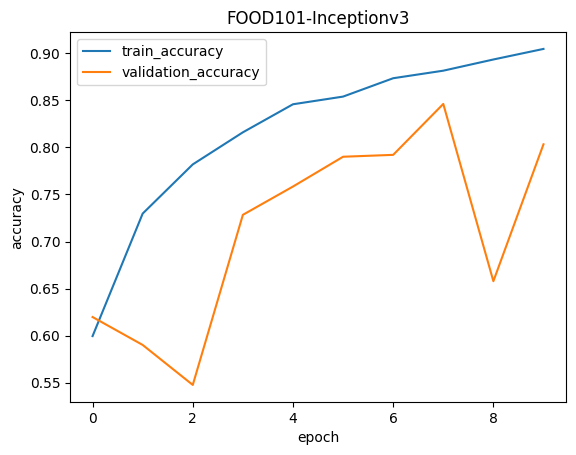

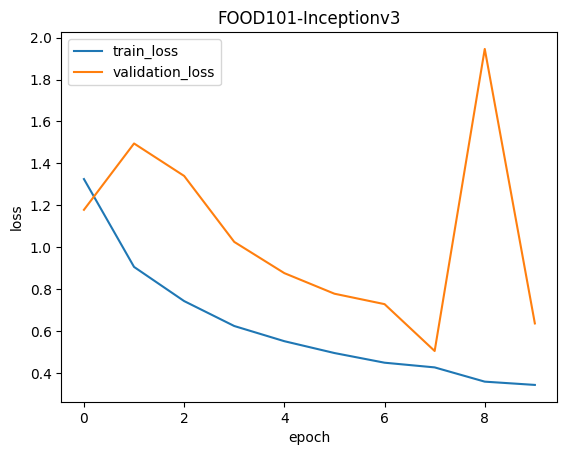

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

 Predicting classes for new images from internet using the best trained model

In [ ]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
model_best = load_model('/content/bestmodel_10class.hdf5',compile = False)

CPU times: user 3.06 s, sys: 101 ms, total: 3.16 s
Wall time: 4.63 s


* **Setting compile=False and clearing the session leads to faster loading of the saved model**
* **Withouth the above addiitons, model loading was taking more than a minute!**

In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    #print(pred)
    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(pred_value)
        plt.show()


In [ ]:
# # Make a list of images and test the trained model
# images = []
# imagepath = '/content/examples/community/en/multi_class_classification/images/'
# images.append(imagepath+'samosa.jpg')
# images.append(imagepath+'pizza.jpg')
# images.append(imagepath+'omelette.jpg')
# predict_class(model_best, images, True)

###<b> Model -1 Semisupervised

In [ ]:
# import os
# import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split

# # Define the list of food items
# food_list = ['samosa','pizza','omelette','apple_pie','baby_back_ribs','baklava','waffles','tacos','strawberry_shortcake','seaweed_salad']

# # Load and preprocess the labeled data
# labeled_data = []
# labeled_labels = []
# labeled_folder = "food-101/train_mini"
# for food in food_list:
#     food_folder = os.path.join(labeled_folder, food)
#     for file in os.listdir(food_folder):
#         image_path = os.path.join(food_folder, file)
#         image = load_img(image_path, target_size=(180, 180))  # Resize the image to 224x224
#         image = img_to_array(image)
#         labeled_data.append(image)
#         labeled_labels.append(food_list.index(food))

# # Convert the labeled data to numpy arrays
# labeled_data = np.array(labeled_data)
# labeled_labels = np.array(labeled_labels)

# # Normalize the pixel values between 0 and 1
# labeled_data = labeled_data.astype('float32') / 255.0

# # Shuffle the labeled data
# labeled_data, labeled_labels = shuffle(labeled_data, labeled_labels, random_state=0)

# # Split the labeled data into labeled and unlabeled data
# labeled_data, unlabeled_data, labeled_labels, _ = train_test_split(labeled_data, labeled_labels, test_size=0.8, stratify=labeled_labels)


In [ ]:

# # Define the CNN model
# model = Sequential()
# model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(180, 180, 3)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(16, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Flatten())
# model.add(Dense(16, activation='relu'))
# model.add(Dense(len(food_list), activation='softmax'))

# # Compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train the model on the labeled data
# history = model.fit(labeled_data, labeled_labels,validation_split=0.2, epochs=30, batch_size=32)


Epoch 1/30
38/38 [==============================] - 3s 28ms/step - loss: 2.2848 - accuracy: 0.1408 - val_loss: 2.2481 - val_accuracy: 0.2433
Epoch 2/30
38/38 [==============================] - 1s 22ms/step - loss: 2.1510 - accuracy: 0.1933 - val_loss: 2.0699 - val_accuracy: 0.2233
Epoch 3/30
38/38 [==============================] - 1s 23ms/step - loss: 2.0615 - accuracy: 0.2217 - val_loss: 2.0540 - val_accuracy: 0.2567
Epoch 4/30
38/38 [==============================] - 1s 22ms/step - loss: 1.9487 - accuracy: 0.2742 - val_loss: 1.9826 - val_accuracy: 0.2900
Epoch 5/30
38/38 [==============================] - 1s 20ms/step - loss: 1.8490 - accuracy: 0.3250 - val_loss: 2.0017 - val_accuracy: 0.2800
Epoch 6/30
38/38 [==============================] - 1s 20ms/step - loss: 1.6859 - accuracy: 0.3650 - val_loss: 2.0049 - val_accuracy: 0.2800
Epoch 7/30
38/38 [==============================] - 1s 19ms/step - loss: 1.4930 - accuracy: 0.4508 - val_loss: 2.1132 - val_accuracy: 0.2833
Epoch 8/30
38

In [ ]:

# # Make predictions on the unlabeled data
# unlabeled_predictions = model.predict(unlabeled_data)
# pseudo_labels = np.argmax(unlabeled_predictions, axis=1)

# # Combine the labeled and pseudo-labeled data
# combined_data = np.concatenate((labeled_data, unlabeled_data), axis=0)
# combined_labels = np.concatenate((labeled_labels, pseudo_labels), axis=0)

# # Shuffle the combined data
# combined_data, combined_labels = shuffle(combined_data, combined_labels, random_state=0)

# # Retrain the model on the combined data
# history1_ = model.fit(combined_data, combined_labels,validation_split=0.2, epochs=10, batch_size=32)


188/188 [==============================] - 2s 9ms/step


In [ ]:

# # Load and preprocess the test data
# test_data = []
# test_labels = []
# test_folder = "food-101/test_mini"
# for food in food_list:
#     food_folder = os.path.join(test_folder, food)
#     for file in os.listdir(food_folder):
#         image_path = os.path.join(food_folder, file)
#         image = load_img(image_path, target_size=(100, 100))
#         image = img_to_array(image)
#         test_data.append(image)
#         test_labels.append(food_list.index(food))

# # Convert the test data to numpy arrays
# test_data = np.array(test_data)
# test_labels = np.array(test_labels)

# # Normalize the pixel values
# test_data = test_data.astype('float32') / 255.0

# # Evaluate the model on the test data
# accuracy = model.evaluate(test_data, test_labels)[1]
# print(f"Accuracy: {accuracy}")


79/79 [==============================] - 1s 8ms/step - loss: 7.6189 - accuracy: 0.3196
Accuracy: 0.319599986076355


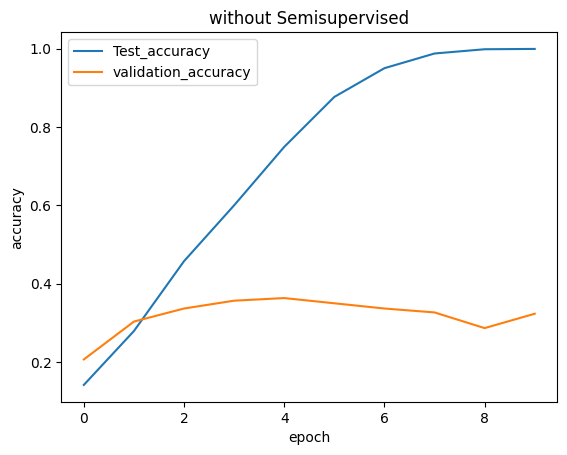

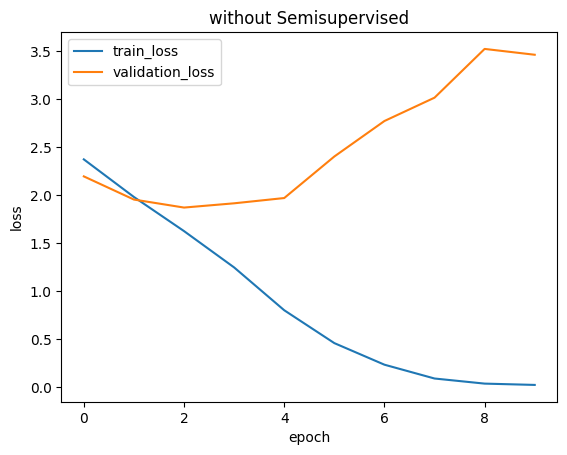

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Test_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'without Semisupervised')
plot_loss(history,'without Semisupervised')

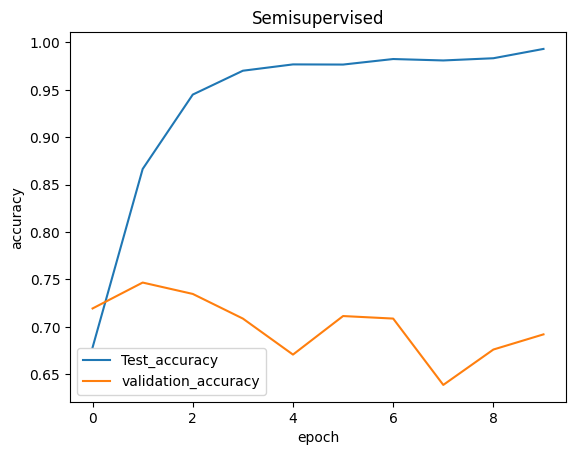

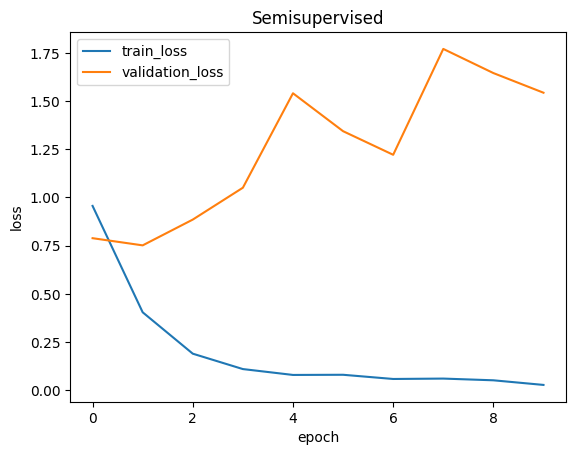

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Test_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history1_,'Semisupervised')
plot_loss(history1_,'Semisupervised')

### <b> Model-2

In [ ]:

# Define the CNN model - VGG16-like architecture
vgg16_model = Sequential()
vgg16_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 3), padding='same'))
vgg16_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D((2, 2)))

vgg16_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D((2, 2)))

vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D((2, 2)))

vgg16_model.add(Flatten())
vgg16_model.add(Dense(4096, activation='relu'))
vgg16_model.add(Dense(4096, activation='relu'))
vgg16_model.add(Dense(len(food_list), activation='softmax'))

# Compile the model
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the VGG16-like model on the labeled data
vgg16_history = vgg16_model.fit(labeled_data, labeled_labels, validation_split=0.2, epochs=10, batch_size=32)


Epoch 1/10
38/38 [==============================] - 12s 169ms/step - loss: 2.4618 - accuracy: 0.0783 - val_loss: 2.3036 - val_accuracy: 0.0967
Epoch 2/10
38/38 [==============================] - 4s 107ms/step - loss: 2.3040 - accuracy: 0.0833 - val_loss: 2.3039 - val_accuracy: 0.0967
Epoch 3/10
38/38 [==============================] - 4s 101ms/step - loss: 2.3028 - accuracy: 0.1042 - val_loss: 2.3044 - val_accuracy: 0.0733
Epoch 4/10
38/38 [==============================] - 4s 105ms/step - loss: 2.3028 - accuracy: 0.1042 - val_loss: 2.3055 - val_accuracy: 0.0733
Epoch 5/10
38/38 [==============================] - 4s 105ms/step - loss: 2.3025 - accuracy: 0.1067 - val_loss: 2.3054 - val_accuracy: 0.0733
Epoch 6/10
38/38 [==============================] - 4s 102ms/step - loss: 2.3026 - accuracy: 0.1067 - val_loss: 2.3067 - val_accuracy: 0.0733
Epoch 7/10
38/38 [==============================] - 4s 105ms/step - loss: 2.3023 - accuracy: 0.1067 - val_loss: 2.3067 - val_accuracy: 0.0733
Epoch

In [ ]:
# Evaluate the VGG16-like model on the test data
vgg16_accuracy = vgg16_model.evaluate(test_data, test_labels)[1]
print(f"VGG16-like Model Accuracy: {vgg16_accuracy}")


79/79 [==============================] - 2s 29ms/step - loss: 2.3032 - accuracy: 0.1000
VGG16-like Model Accuracy: 0.10000000149011612


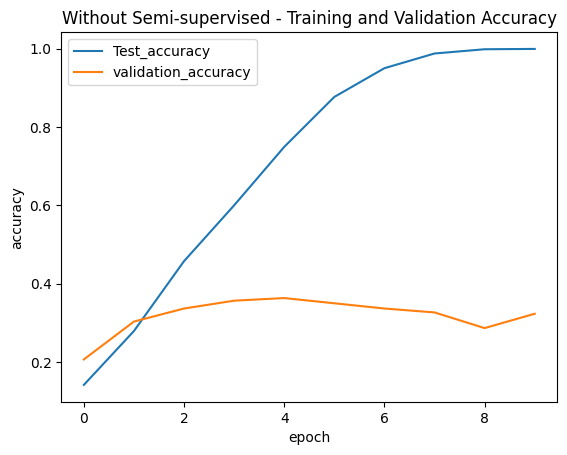

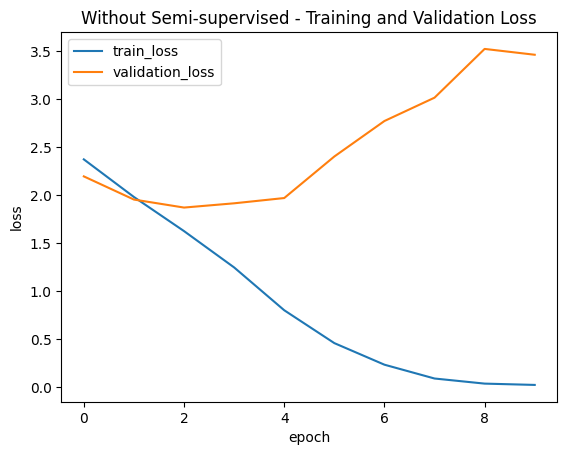

In [ ]:

# Plot the train and validation plots for the initial model
plot_accuracy(history, 'Without Semi-supervised - Training and Validation Accuracy')
plot_loss(history, 'Without Semi-supervised - Training and Validation Loss')


In [ ]:
# ResNet, AlexNet, VGGNet, Inception

###<b> Model 3 - VGG19

In [ ]:

# Define the VGG19 model
vgg19_model = Sequential()
vgg19_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 3)))
vgg19_model.add(MaxPooling2D((2, 2)))
vgg19_model.add(Conv2D(128, (3, 3), activation='relu'))
vgg19_model.add(MaxPooling2D((2, 2)))
vgg19_model.add(Conv2D(256, (3, 3), activation='relu'))
vgg19_model.add(MaxPooling2D((2, 2)))
vgg19_model.add(Flatten())
vgg19_model.add(Dense(128, activation='relu'))
vgg19_model.add(Dense(len(food_list), activation='softmax'))

# Compile the model
vgg19_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the VGG19 model on the labeled data
vgg19_history = vgg19_model.fit(labeled_data, labeled_labels, validation_split=0.2, epochs=10, batch_size=32)


Epoch 1/10
38/38 [==============================] - 4s 46ms/step - loss: 2.2713 - accuracy: 0.1292 - val_loss: 2.1530 - val_accuracy: 0.1567
Epoch 2/10
38/38 [==============================] - 1s 25ms/step - loss: 2.0964 - accuracy: 0.2133 - val_loss: 2.0367 - val_accuracy: 0.2733
Epoch 3/10
38/38 [==============================] - 1s 24ms/step - loss: 1.9940 - accuracy: 0.2850 - val_loss: 1.8988 - val_accuracy: 0.3167
Epoch 4/10
38/38 [==============================] - 1s 23ms/step - loss: 1.8102 - accuracy: 0.3392 - val_loss: 1.7870 - val_accuracy: 0.3600
Epoch 5/10
38/38 [==============================] - 1s 23ms/step - loss: 1.7096 - accuracy: 0.4067 - val_loss: 1.8063 - val_accuracy: 0.3500
Epoch 6/10
38/38 [==============================] - 1s 25ms/step - loss: 1.4793 - accuracy: 0.4833 - val_loss: 1.9415 - val_accuracy: 0.3100
Epoch 7/10
38/38 [==============================] - 1s 25ms/step - loss: 1.2745 - accuracy: 0.5558 - val_loss: 1.8834 - val_accuracy: 0.3967
Epoch 8/10
38

In [ ]:

# Evaluate the VGG19 model on the test data
vgg19_accuracy = vgg19_model.evaluate(test_data, test_labels)[1]
print(f"VGG19 Model Accuracy: {vgg19_accuracy}")


79/79 [==============================] - 1s 10ms/step - loss: 2.6200 - accuracy: 0.3648
VGG19 Model Accuracy: 0.36480000615119934


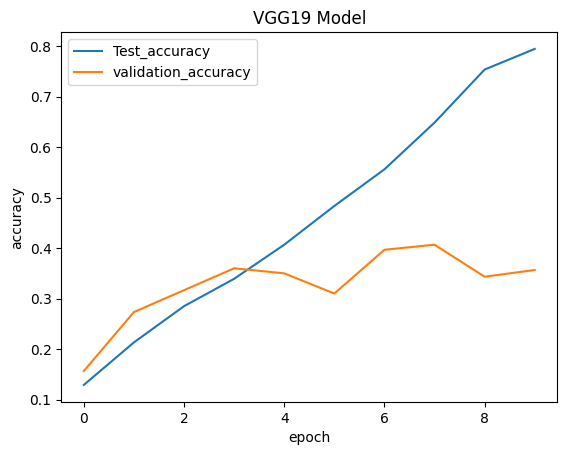

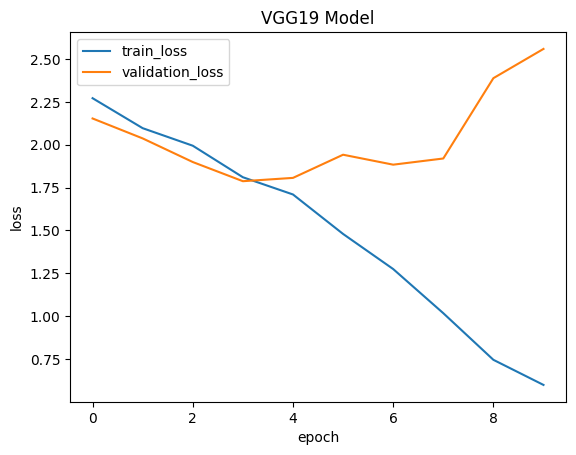

In [ ]:


# Plot training and validation accuracy for the VGG19 model
plot_accuracy(vgg19_history, 'VGG19 Model')
plot_loss(vgg19_history, 'VGG19 Model')

### <b> Model-4 InceptionNet

In [ ]:
# Define the InceptionNet model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(food_list), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the labeled data
history = model.fit(labeled_data, labeled_labels, validation_split=0.2, epochs=30, batch_size=32)


Epoch 1/30
38/38 [==============================] - 52s 209ms/step - loss: 2.2661 - accuracy: 0.2100 - val_loss: 2.4952 - val_accuracy: 0.1333
Epoch 2/30
38/38 [==============================] - 4s 96ms/step - loss: 1.8454 - accuracy: 0.3558 - val_loss: 2.6596 - val_accuracy: 0.1133
Epoch 3/30
38/38 [==============================] - 3s 83ms/step - loss: 1.5067 - accuracy: 0.5008 - val_loss: 3.7072 - val_accuracy: 0.1333
Epoch 4/30
38/38 [==============================] - 3s 72ms/step - loss: 1.1659 - accuracy: 0.6133 - val_loss: 16.1138 - val_accuracy: 0.1467
Epoch 5/30
38/38 [==============================] - 3s 67ms/step - loss: 1.1487 - accuracy: 0.6208 - val_loss: 7.9473 - val_accuracy: 0.1100
Epoch 6/30
38/38 [==============================] - 3s 67ms/step - loss: 1.7368 - accuracy: 0.4083 - val_loss: 61.8516 - val_accuracy: 0.0867
Epoch 7/30
38/38 [==============================] - 3s 72ms/step - loss: 1.4518 - accuracy: 0.5142 - val_loss: 4.2959 - val_accuracy: 0.1333
Epoch 8/3

In [ ]:
# Evaluate the model on the test data
accuracy = model.evaluate(test_data, test_labels)[1]
print(f"Accuracy: {accuracy}")

79/79 [==============================] - 2s 22ms/step - loss: 50.1568 - accuracy: 0.2416
Accuracy: 0.24160000681877136


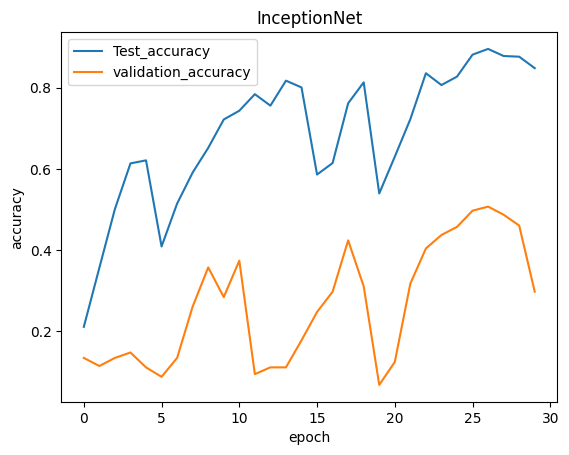

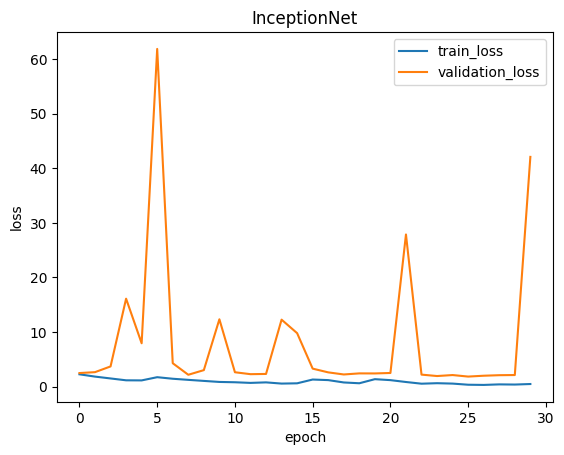

In [ ]:
plot_accuracy(history, 'InceptionNet')
plot_loss(history, 'InceptionNet')

###<b> Model-5- Alexnet

In [ ]:

# Define the first CNN model (AlexNet-like model)
model1 = Sequential()
model1.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(100, 100, 3)))
model1.add(MaxPooling2D((3, 3), strides=(2, 2)))
model1.add(Conv2D(256, (5, 5), padding="same", activation='relu'))
model1.add(MaxPooling2D((3, 3), strides=(2, 2)))
model1.add(Conv2D(384, (3, 3), padding="same", activation='relu'))
model1.add(Conv2D(384, (3, 3), padding="same", activation='relu'))
model1.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model1.add(MaxPooling2D((3, 3), strides=(2, 2)))
model1.add(Flatten())
model1.add(Dense(4096, activation='relu'))
model1.add(Dense(4096, activation='relu'))
model1.add(Dense(len(food_list), activation='softmax'))

# Compile the first model
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the first model on the labeled data
history1 = model1.fit(labeled_data, labeled_labels, validation_split=0.2, epochs=10, batch_size=32)


Epoch 1/10
38/38 [==============================] - 5s 41ms/step - loss: 2.4042 - accuracy: 0.0950 - val_loss: 2.3051 - val_accuracy: 0.0867
Epoch 2/10
38/38 [==============================] - 1s 19ms/step - loss: 2.3035 - accuracy: 0.1017 - val_loss: 2.3058 - val_accuracy: 0.0733
Epoch 3/10
38/38 [==============================] - 1s 21ms/step - loss: 2.3032 - accuracy: 0.0925 - val_loss: 2.3069 - val_accuracy: 0.0867
Epoch 4/10
38/38 [==============================] - 1s 19ms/step - loss: 2.3027 - accuracy: 0.1025 - val_loss: 2.3062 - val_accuracy: 0.0733
Epoch 5/10
38/38 [==============================] - 1s 19ms/step - loss: 2.3026 - accuracy: 0.0958 - val_loss: 2.3068 - val_accuracy: 0.0733
Epoch 6/10
38/38 [==============================] - 1s 21ms/step - loss: 2.3026 - accuracy: 0.1067 - val_loss: 2.3072 - val_accuracy: 0.0733
Epoch 7/10
38/38 [==============================] - 1s 20ms/step - loss: 2.3028 - accuracy: 0.1067 - val_loss: 2.3076 - val_accuracy: 0.0733
Epoch 8/10
38

In [ ]:
# Evaluate the first model on the test data
accuracy1 = model1.evaluate(test_data, test_labels)[1]
print(f"First model accuracy: {accuracy1}")

79/79 [==============================] - 1s 9ms/step - loss: 2.3030 - accuracy: 0.1000
First model accuracy: 0.10000000149011612


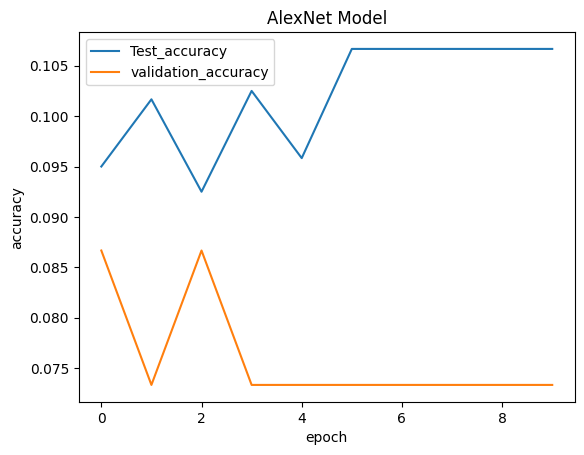

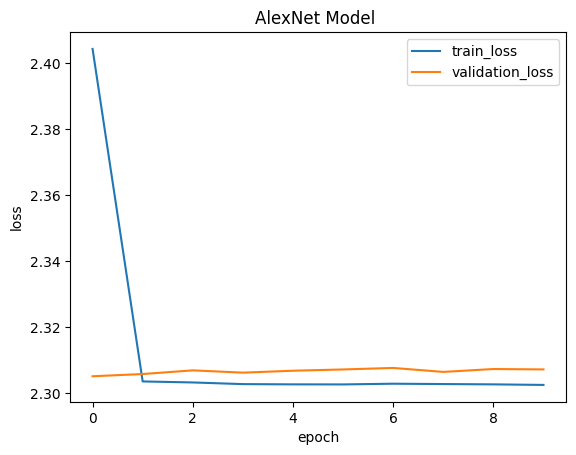

In [ ]:
plot_accuracy(history1, 'AlexNet Model')
plot_loss(history1, 'AlexNet Model ')

###<b> Model-6 Resnet

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


# Load the pre-trained ResNet50 model (excluding the top layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Add a global average pooling layer and a dense layer for classification
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(food_list), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the labeled data
history = model.fit(labeled_data, labeled_labels, validation_split=0.2, epochs=10, batch_size=32)


94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/10
38/38 [==============================] - 53s 200ms/step - loss: 2.0965 - accuracy: 0.3275 - val_loss: 279.5259 - val_accuracy: 0.0967
Epoch 2/10
38/38 [==============================] - 4s 107ms/step - loss: 1.5652 - accuracy: 0.4817 - val_loss: 9.5061 - val_accuracy: 0.0800
Epoch 3/10
38/38 [==============================] - 4s 106ms/step - loss: 1.1431 - accuracy: 0.6175 - val_loss: 3.7704 - val_accuracy: 0.1033
Epoch 4/10
38/38 [==============================] - 4s 107ms/step - loss: 0.7933 - accuracy: 0.7475 - val_loss: 3.0463 - val_accuracy: 0.1167
Epoch 5/10
38/38 [==============================] - 4s 109ms/step - loss: 0.5324 - accuracy: 0.8283 - val_loss: 3.1171 - val_accuracy: 0.1000
Epoch 6/10
38/38 [==============================] - 4s 109ms/step - loss: 0.5136 - accuracy: 0.8383 - val_loss: 2.9426 - val_accuracy: 0.1233
Epoch 7/10
38/38 [==============================] - 4s 107ms/step - loss: 0.3623

In [ ]:
# Evaluate the model on the test data
accuracy = model.evaluate(test_data, test_labels)[1]
print(f"Accuracy: {accuracy}")

79/79 [==============================] - 3s 38ms/step - loss: 4.9578 - accuracy: 0.1000
Accuracy: 0.10000000149011612


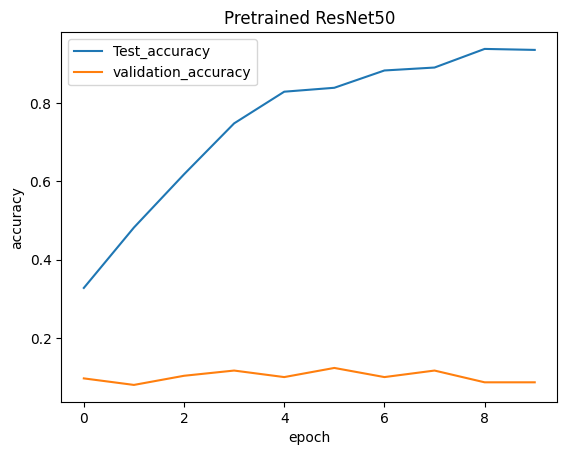

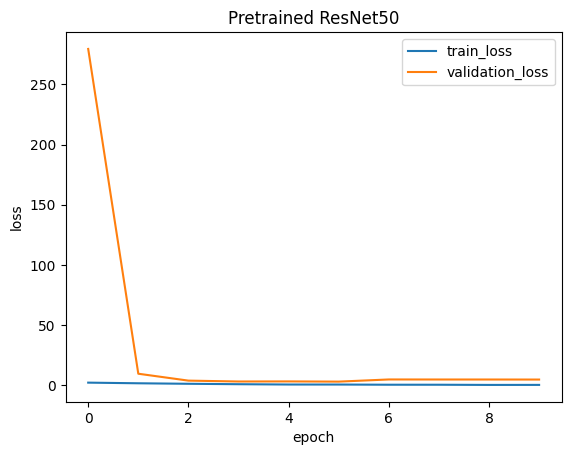

In [ ]:
plot_accuracy(history, 'Pretrained ResNet50')
plot_loss(history, 'Pretrained ResNet50')